# TikTok Account Clustering using Hierarchical Methods

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv('influencers_log_and_minmax_scaled.csv')

# Check missing values
print("Missing values:\n", df.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
display(df.describe().T)

Missing values:
 followers_log_minmax           0
average_views_log_minmax       0
average_likes_log_minmax       0
average_comments_log_minmax    0
average_shares_log_minmax      0
dtype: int64

Summary statistics:


,count,mean,std,min,25%,50%,75%,max
followers_log_minmax,1000.0,0.635119,0.146819,0.0,0.558589,0.652423,0.734137,1.0
average_views_log_minmax,1000.0,0.310613,0.125527,0.0,0.220732,0.292983,0.377625,1.0
average_likes_log_minmax,1000.0,0.379729,0.100443,0.0,0.314933,0.366571,0.429596,1.0
average_comments_log_minmax,1000.0,0.664764,0.093263,0.0,0.618730,0.665636,0.712551,1.0
average_shares_log_minmax,1000.0,0.248645,0.112436,0.0,0.170878,0.239317,0.319410,1.0


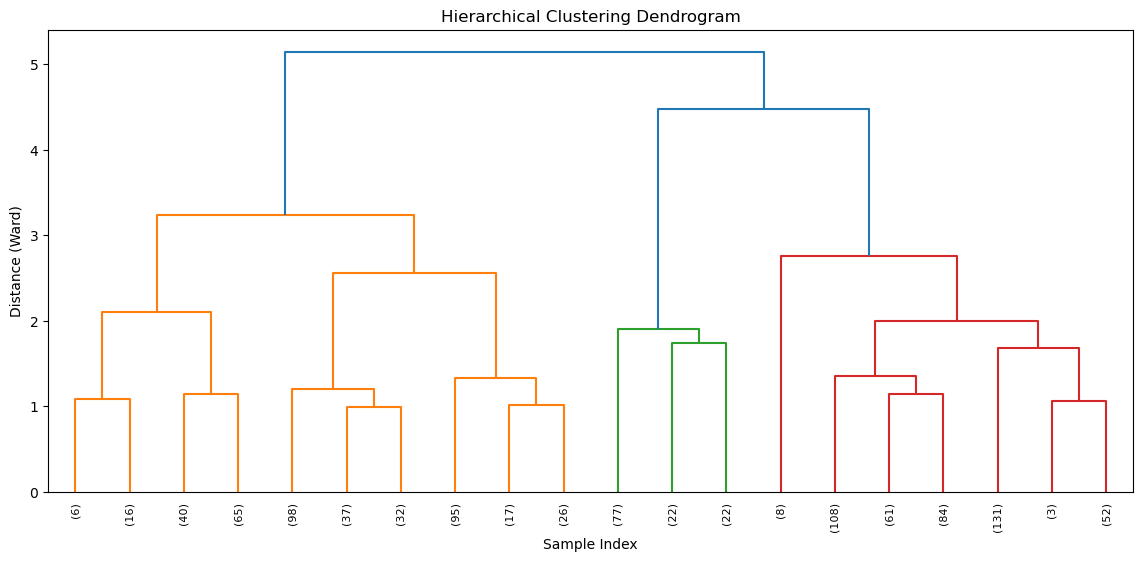

In [3]:
# Perform hierarchical clustering
Z = linkage(df, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance (Ward)')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8., truncate_mode='lastp', p=20)
plt.show()

In [7]:
# Determine optimal clusters using the "elbow" method (based on distance jumps)
last_merges = Z[-10:, 2]  # Last 10 merge distances
last_merges_rev = last_merges[::-1]  # Reverse to ascending order
idxs = np.arange(1, len(last_merges)+1)

In [9]:
# Calculate acceleration
acceleration = np.diff(last_merges_rev, 2)
optimal_clusters = acceleration.argmax() + 2  # +2 because diff reduces size

print(f"Optimal number of clusters (elbow method): {optimal_clusters}")

Optimal number of clusters (elbow method): 3


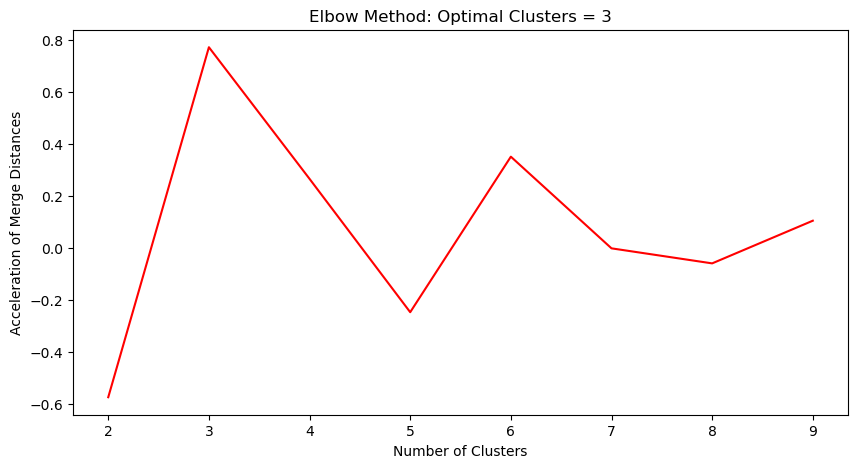

In [11]:
# Plot the elbow curve
plt.figure(figsize=(10,5))
plt.plot(idxs[:-2]+1, acceleration, 'r-')
plt.xlabel('Number of Clusters')
plt.ylabel('Acceleration of Merge Distances')
plt.title('Elbow Method: Optimal Clusters = {}'.format(optimal_clusters))
plt.show()


In [13]:
# Assign clusters to data points
clusters = fcluster(Z, optimal_clusters, criterion='maxclust')
df['Cluster'] = clusters

In [15]:
# Display cluster distribution
print("\nCluster Distribution:")
print(df['Cluster'].value_counts().sort_index())


Cluster Distribution:
Cluster
1    432
2    121
3    447
Name: count, dtype: int64


Optimal number of clusters (silhouette score): 3


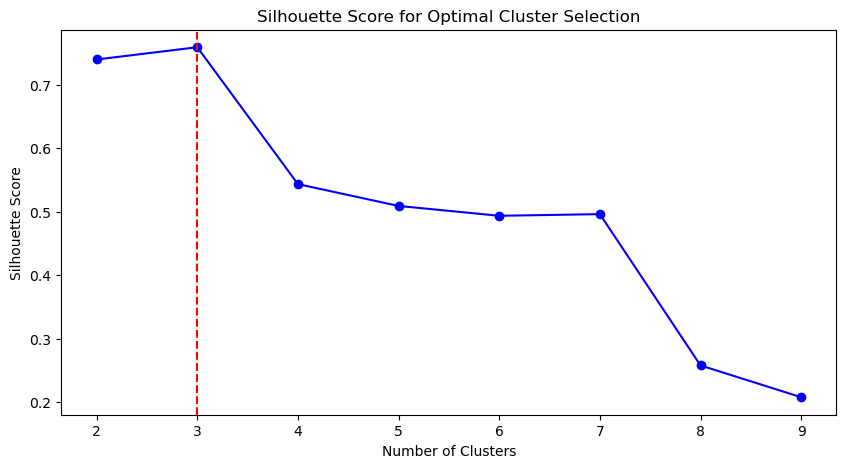

In [17]:
# Determine optimal clusters using silhouette score
possible_clusters = range(2, 10)
silhouette_scores = []

for k in possible_clusters:
    clusters = fcluster(Z, k, criterion='maxclust')
    silhouette_scores.append(silhouette_score(df, clusters))

optimal_clusters = possible_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (silhouette score): {optimal_clusters}")

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(possible_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Cluster Selection')
plt.axvline(x=optimal_clusters, color='r', linestyle='--')
plt.show()

In [19]:
# Assign final clusters
final_clusters = fcluster(Z, optimal_clusters, criterion='maxclust')
df['Cluster'] = final_clusters

# Display cluster distribution
print("\nCluster Distribution:")
print(df['Cluster'].value_counts().sort_index())


Cluster Distribution:
Cluster
1    432
2    121
3    447
Name: count, dtype: int64


In [21]:
# --- PCA Visualization ---
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
data_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
data_pca['Cluster'] = final_clusters

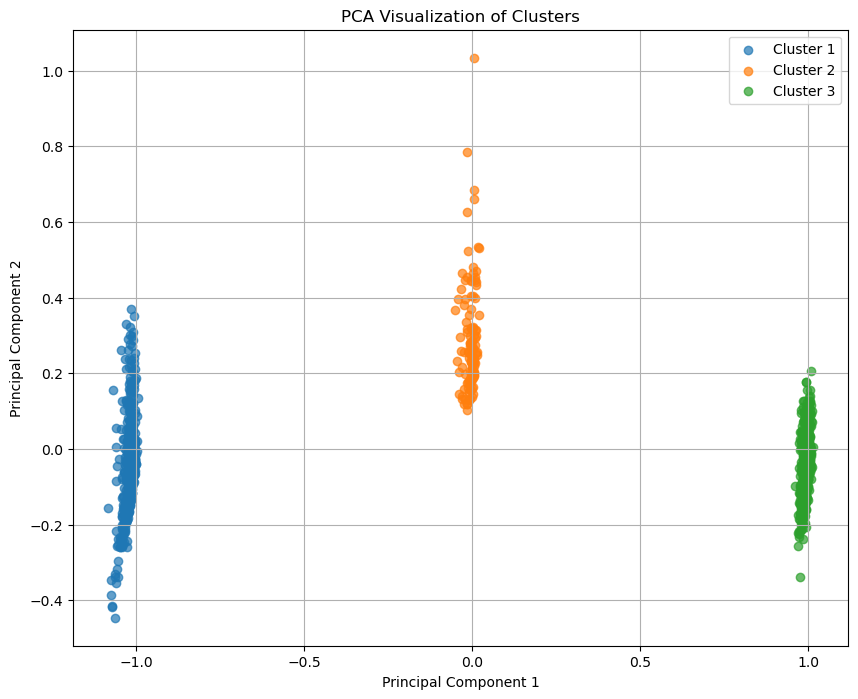

In [23]:
# Plot clusters in PCA space
plt.figure(figsize=(10, 8))
for cluster in np.unique(final_clusters):
    plt.scatter(
        data_pca[data_pca['Cluster'] == cluster]['PC1'],
        data_pca[data_pca['Cluster'] == cluster]['PC2'],
        label=f'Cluster {cluster}',
        alpha=0.7
    )
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [25]:
print(pca.explained_variance_ratio_)

[0.93963568 0.02663787]


<Figure size 640x480 with 0 Axes>

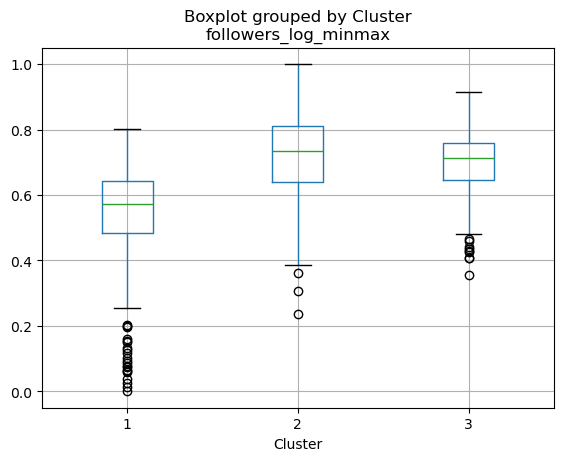

<Figure size 640x480 with 0 Axes>

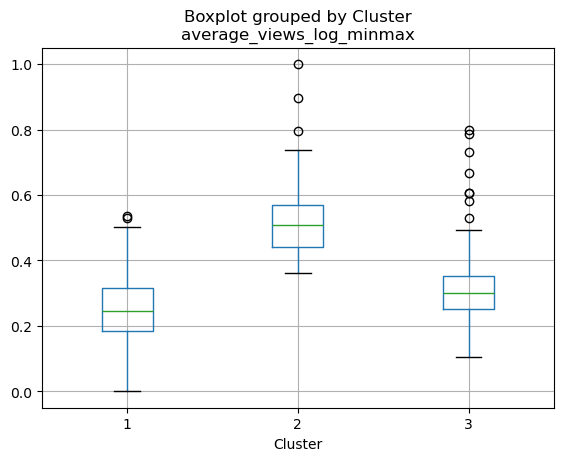

<Figure size 640x480 with 0 Axes>

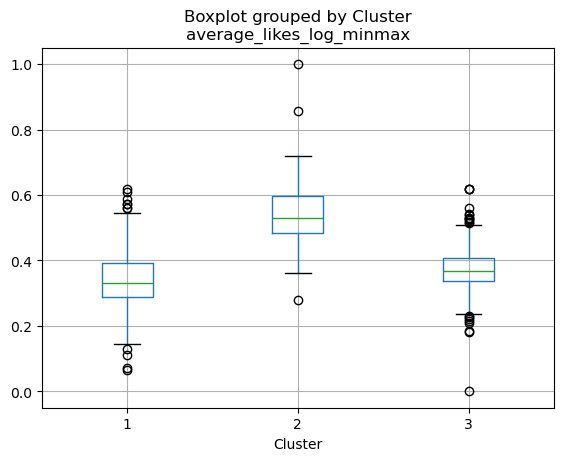

<Figure size 640x480 with 0 Axes>

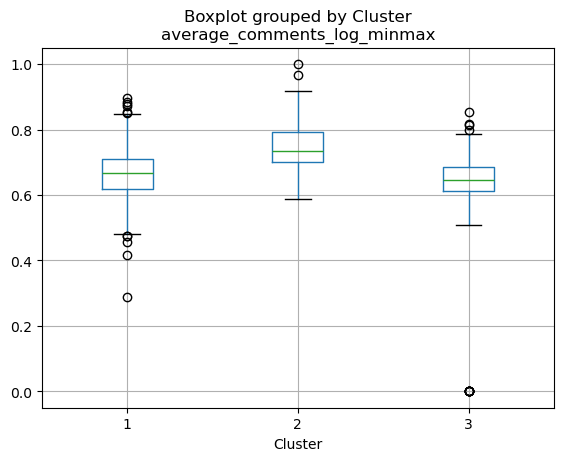

<Figure size 640x480 with 0 Axes>

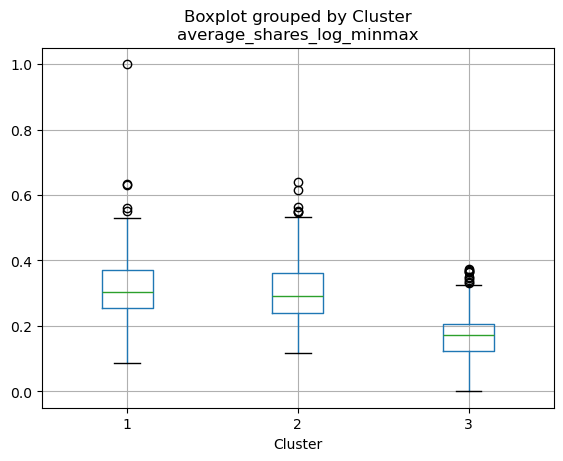

In [27]:
for feature in df.columns[:-1]:  # Exclude 'Cluster' column
    plt.figure()
    df.boxplot(column=feature, by='Cluster')
    plt.title(feature)

Cluster Statistics:
        followers_log_minmax        average_views_log_minmax         \
                        mean median                     mean median   
Cluster                                                               
1                       0.54   0.57                     0.25   0.25   
2                       0.72   0.73                     0.52   0.51   
3                       0.70   0.71                     0.31   0.30   

        average_likes_log_minmax        average_comments_log_minmax         \
                            mean median                        mean median   
Cluster                                                                      
1                           0.34   0.33                        0.67   0.67   
2                           0.54   0.53                        0.75   0.73   
3                           0.37   0.37                        0.64   0.65   

        average_shares_log_minmax         
                             mean median 

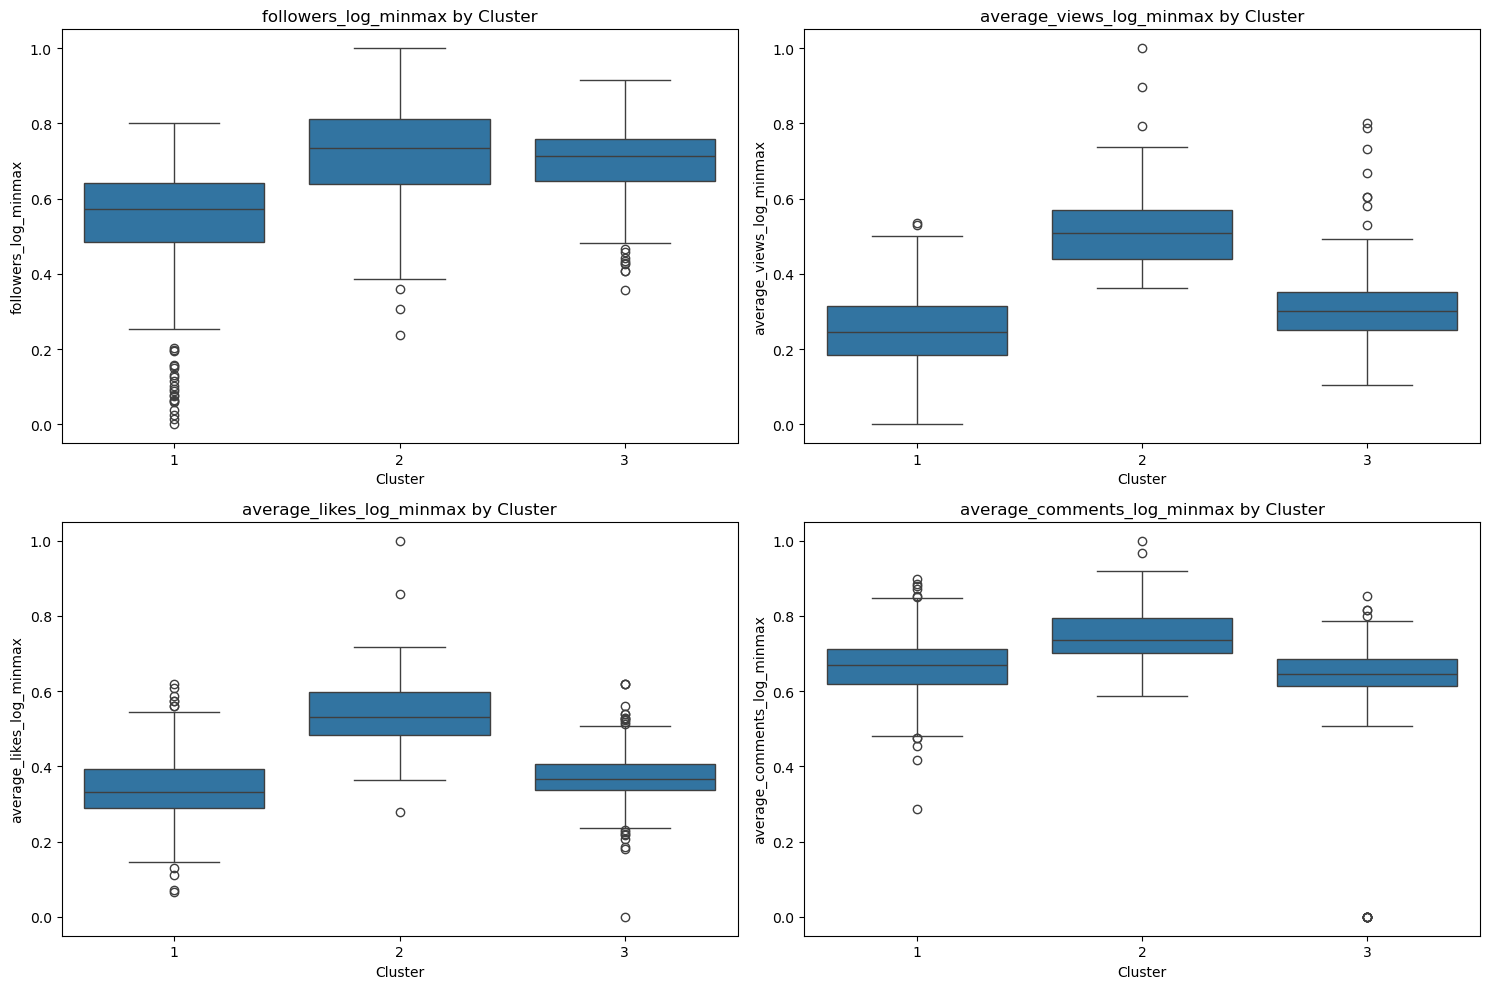


Labeled data saved to 'labeled_influencer_clusters.csv'


In [29]:
# 1. Analyze Feature Distributions per Cluster
feature_stats = df.groupby('Cluster').agg({
    'followers_log_minmax': ['mean', 'median'],
    'average_views_log_minmax': ['mean', 'median'],
    'average_likes_log_minmax': ['mean', 'median'],
    'average_comments_log_minmax': ['mean', 'median'],
    'average_shares_log_minmax': ['mean', 'median']
}).round(2)

print("Cluster Statistics:")
print(feature_stats)

# 2. Visualize Key Features by Cluster
plt.figure(figsize=(15, 10))
features_to_plot = ['followers_log_minmax', 'average_views_log_minmax', 
                   'average_likes_log_minmax', 'average_comments_log_minmax']

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

# 3. Assign Business Labels Based on Patterns
cluster_profiles = {
    1: {
        'label': 'High-Followers-Low-Engagement',
        'characteristics': {
            'followers': 'high',
            'engagement_metrics': 'low'
        }
    },
    2: {
        'label': 'Niche-Influencers',
        'characteristics': {
            'followers': 'medium',
            'engagement_metrics': 'high'
        }
    },
    3: {
        'label': 'General-Influencers',
        'characteristics': {
            'followers': 'medium',
            'engagement_metrics': 'medium'
        }
    }
}

# 4. Add Labels to Your Data
df['Cluster_Label'] = df['Cluster'].map({k: v['label'] for k, v in cluster_profiles.items()})

# 5. Validate Against Known Categories (if available)
# Example: Compare with manually labeled data
if 'known_category' in df.columns:
    cross_tab = pd.crosstab(df['Cluster_Label'], df['known_category'])
    print("\nCluster vs Known Category Alignment:")
    print(cross_tab)

# 6. Save Labeled Data
df.to_csv('labeled_influencer_clusters.csv', index=False)
print("\nLabeled data saved to 'labeled_influencer_clusters.csv'")